In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df=pd.read_csv('/content/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [5]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

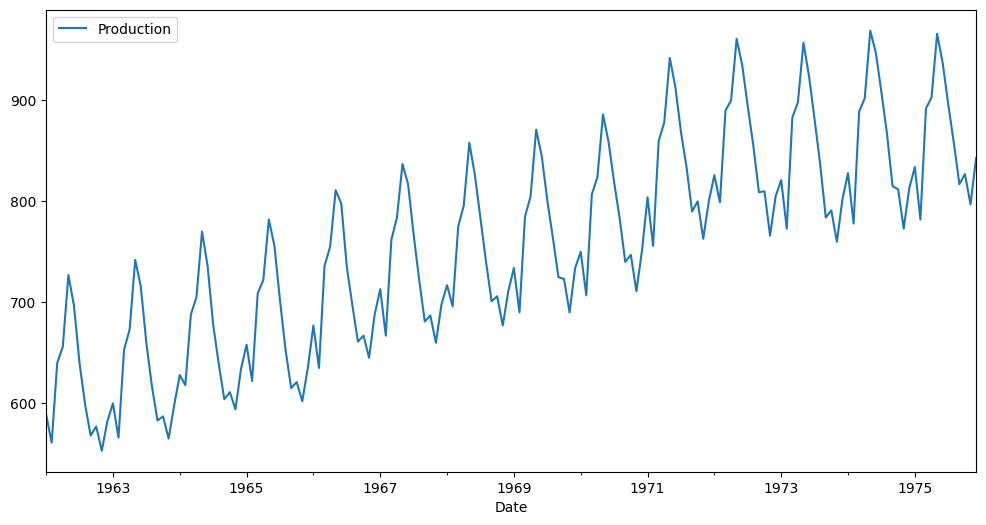

In [6]:
df.plot(figsize=(12,6))

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

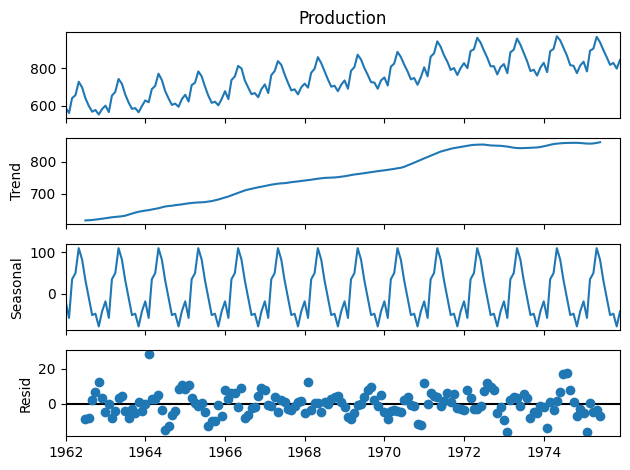

In [8]:
results=seasonal_decompose(df['Production'])
results.plot();

In [9]:
len(df)

168

In [10]:
train=df.iloc[:156]
test=df.iloc[156:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [12]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [13]:
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [14]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
n_input=12
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [17]:
X,y=generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462 0.24759615 0.41826923 0.34615385
 0.20913462 0.11057692 0.03605769 0.05769231 0.         0.06971154]
Predict this y: 
 [[0.11298077]]


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [19]:
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 3s 9ms/step - loss: 0.0400
Epoch 2/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0214
Epoch 3/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0180
Epoch 4/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0131
Epoch 5/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0101
Epoch 6/50
144/144 [==============================] - 1s 9ms/step - loss: 0.0079
Epoch 7/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 8/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0048
Epoch 9/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0048
Epoch 10/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0066
Epoch 11/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0039
Epoch 12/50
144/144 [==============================] - 1s 8ms/step - loss: 0.0041
Epoch 13/50
144/144 [===

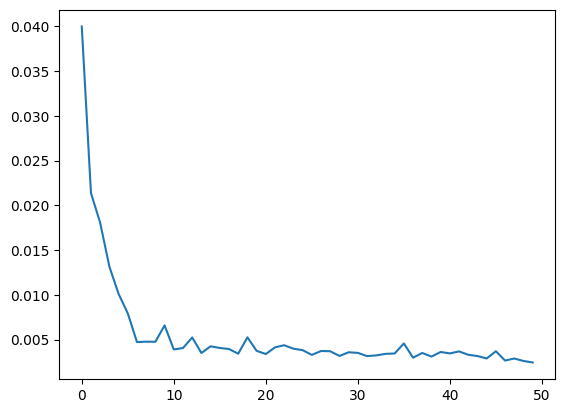

In [22]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [23]:
last_train_batch=scaled_train[-12:]

In [24]:
last_train_batch=last_train_batch.reshape((1,n_input,n_features))

In [25]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 208ms/step


array([[0.62717915]], dtype=float32)

In [26]:
scaled_test[0]

array([0.67548077])

In [28]:
test_predictions=[]

first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape(1,n_input,n_features)

for i in range(len(test)):
  current_pred=model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 22ms/step


In [29]:
test_predictions

[array([0.62717915], dtype=float32),
 array([0.667978], dtype=float32),
 array([0.8290324], dtype=float32),
 array([0.95349276], dtype=float32),
 array([1.0636927], dtype=float32),
 array([1.0521057], dtype=float32),
 array([0.96573776], dtype=float32),
 array([0.82763743], dtype=float32),
 array([0.7128353], dtype=float32),
 array([0.6499015], dtype=float32),
 array([0.6133289], dtype=float32),
 array([0.63026565], dtype=float32)]

In [30]:
true_predictions=scaler.inverse_transform(test_predictions)

In [31]:
test['Predictons']=true_predictions

<ipython-input-31-8653fb7e9c6e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictons']=true_predictions


<Axes: xlabel='Date'>

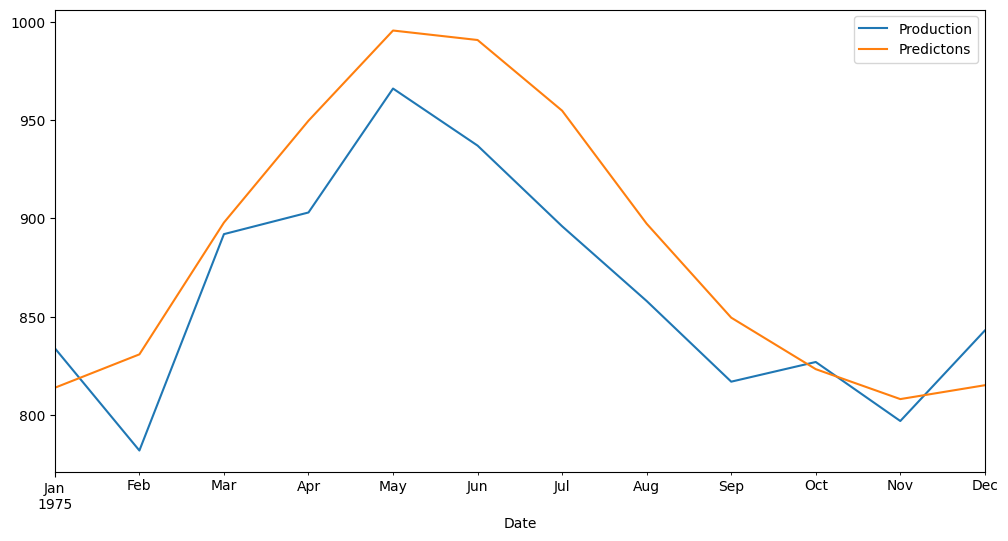

In [33]:
test.plot(figsize=(12,6))

In [35]:
test.head()

,Production,Predictons
Date,,
1975-01-01,834,813.906525
1975-02-01,782,830.878843
1975-03-01,892,897.877487
1975-04-01,903,949.652988
1975-05-01,966,995.496159


In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictons']))
print(rmse)

36.194133376822
